In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier
import tensorflow as tf
from textblob import TextBlob
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from google.colab import drive
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.combine import SMOTEENN
from joblib import parallel_backend
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#LSTM model


In [ ]:


# Prepare the hybrid features
def prepare_hybrid_features(df, max_words=15000, max_len=100):

    # Tokenizer for text features
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    texts = [' '.join(tweet) if isinstance(tweet, list) else str(tweet) for tweet in df['processed_tweet']]
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')




    # Numerical features
    numerical_features = [
        'num_links', 'num_hashtags', 'num_mentions', 'num_chars',
        'num_followers', 'num_friends', 'is_verified', 'account_age',
        'tweet_length', 'statuses_count', 'favorites_count', 'listed_count', 'sentiment_polarity',
        'friends_follower_ratio'
    ]
    numerical_data = df[numerical_features].values



    return padded_sequences, numerical_data, tokenizer

# Create the hybrid LSTM model
def create_hybrid_lstm_model(max_words, max_len, num_numerical_features, embedding_dim=100, lstm_units=32):
    # Text input branch
    text_input = Input(shape=(max_len,))
    embedding = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len)(text_input)
    lstm_out = LSTM(lstm_units, return_sequences=True)(embedding)
    lstm_out = LSTM(lstm_units)(lstm_out)
    lstm_out = Dropout(0.7)(lstm_out)  # Increased dropout rate

    # Numerical input branch
    numerical_input = Input(shape=(num_numerical_features,))
    numerical_dense = Dense(32, activation='relu')(numerical_input)
    numerical_dense = Dropout(0.3)(numerical_dense)

    # Combine both branches
    combined = concatenate([lstm_out, numerical_dense])

    # Output layers
    dense = Dense(64, activation='relu')(combined)
    dense = Dropout(0.6)(dense)  # Increased dropout rate
    output = Dense(1, activation='sigmoid')(dense)

    # Create model
    model = Model(inputs=[text_input, numerical_input], outputs=output)

    # Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

    return model


In [ ]:
# Train the hybrid LSTM model
def train_hybrid_lstm_model(df, max_words=15000, max_len=100, epochs=10, batch_size=32):
    # Prepare features
    padded_sequences, numerical_data, tokenizer = prepare_hybrid_features(df, max_words, max_len)
    labels = df['label'].values

    # Apply ADASYN for oversampling
    adasyn = ADASYN(random_state=42)
    X_resampled, y_resampled = adasyn.fit_resample(np.hstack((padded_sequences, numerical_data)), labels)

    # Split resampled data into text and numerical parts
    X_text = X_resampled[:, :max_len]
    X_num = X_resampled[:, max_len:]

    # Split the data into training and testing sets
    X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
        X_text, X_num, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
    )

    # Create model
    model = create_hybrid_lstm_model(
        max_words=max_words,
        max_len=max_len,
        num_numerical_features=numerical_data.shape[1]
    )

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Reduce patience to prevent overfitting
    model_checkpoint = ModelCheckpoint('best_hybrid_lstm_model.keras', monitor='val_accuracy', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)  # Added learning rate scheduler

    # Train model
    history = model.fit(
        [X_text_train, X_num_train], y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.3,
       callbacks=[early_stopping, model_checkpoint, reduce_lr]
    )

    # Evaluate model
    evaluation = model.evaluate([X_text_test, X_num_test], y_test)




    y_pred_proba = model.predict([X_text_test, X_num_test])
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Generate Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC Score: {roc_auc:.4f}")
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix LSTM')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    plt.close()
     # Generate Classification Report
    cr = classification_report(y_test, y_pred, output_dict=True)

    # Convert classification report to a DataFrame for easier viewing
    cr_df = pd.DataFrame(cr).transpose()



    # Print Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))



    return model, tokenizer, history, evaluation


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7657 - auc_12: 0.8291 - loss: 0.5550 - val_accuracy: 0.8532 - val_auc_12: 0.9165 - val_loss: 0.3363 - learning_rate: 0.0010
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8873 - auc_12: 0.9511 - loss: 0.2740 - val_accuracy: 0.8540 - val_auc_12: 0.9091 - val_loss: 0.3284 - learning_rate: 0.0010
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9589 - auc_12: 0.9904 - loss: 0.1300 - val_accuracy: 0.8338 - val_auc_12: 0.9025 - val_loss: 0.4845 - learning_rate: 0.0010
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9804 - auc_12: 0.9985 - loss: 0.0523 - val_accuracy: 0.8002 - val_auc_12: 0.8884 - val_loss: 0.7013 - learning_rate: 0.0010
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9894 - auc_12: 0.9995 - loss: 0.0313 - val_accuracy: 0.8326 - val_auc_12: 0.8814 - val_loss: 0.8442 - learning_rate: 0.0010
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - a

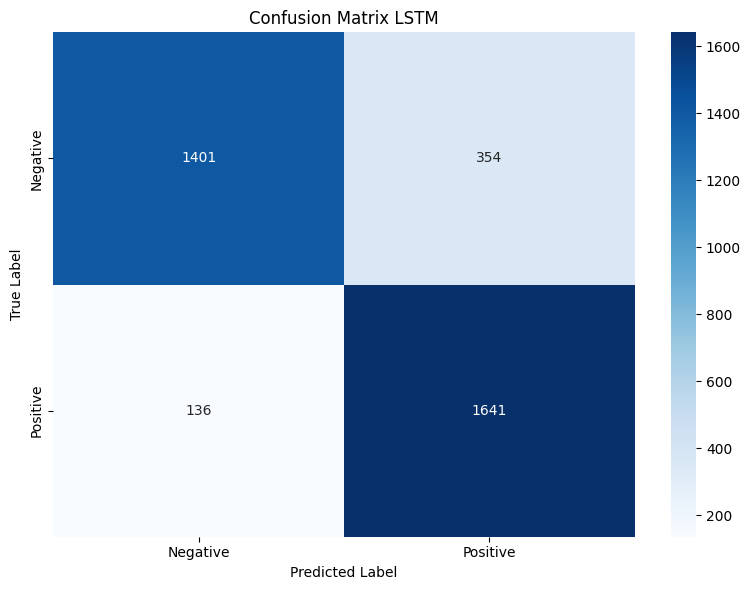

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      1755
           1       0.82      0.92      0.87      1777

    accuracy                           0.86      3532
   macro avg       0.87      0.86      0.86      3532
weighted avg       0.87      0.86      0.86      3532



In [ ]:
#run the model
df=pd.read_csv("/content/drive/MyDrive/Social Bot detection/Twibot/english_data.csv")
model, tokenizer, history, evaluation = train_hybrid_lstm_model(df)






#Bidirectional LSTM with different parameters and sentiment features

In [ ]:
# Prepare Features
def prepare_lstm_features(df, max_words=20000, max_len=100):

    # Prepare text features
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    texts = [' '.join(tweet) if isinstance(tweet, list) else str(tweet) for tweet in df['processed_tweet']]
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

    # Prepare numerical features
     # Extract sentiment features

    df['sentiment_subjectivity'] = df['processed_tweet'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

    numerical_features = [
        'account_age', 'favorites_count', 'friends_follower_ratio',
        'listed_count', 'num_followers', 'num_friends', 'tweet_length',
        'statuses_count', 'is_verified', 'num_links', 'num_hashtags',
        'num_mentions', 'num_chars', 'sentiment_polarity', 'sentiment_subjectivity'
    ]
    numerical_data = df[numerical_features].values

    return padded_sequences, numerical_data, tokenizer

# Create BI-LSTM Model that combines text and numerical features
def create_hybrid_lstm_model(max_words, max_len, num_numerical_features, embedding_dim=100, lstm_units=32):

    # Text input branch
    text_input = Input(shape=(max_len,))
    embedding = Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len)(text_input)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding)
    lstm_out = Bidirectional(LSTM(lstm_units))(lstm_out)
    lstm_out = Dropout(0.4)(lstm_out)  # Increase dropout to reduce overfitting

    # Numerical input branch
    numerical_input = Input(shape=(num_numerical_features,))
    numerical_dense = Dense(32, activation='relu')(numerical_input)
    numerical_dense = Dropout(0.3)(numerical_dense)

    # Combine both branches
    combined = concatenate(([lstm_out, numerical_dense]))

    # Output layers
    dense = Dense(64, activation='relu')(combined)
    dense = Dropout(0.4)(dense)  # Increase dropout to reduce overfitting
    output = Dense(1, activation='sigmoid')(dense)

    # Create model
    model = Model(inputs=[text_input, numerical_input], outputs=output)

    # Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

    return model


In [ ]:
def train_lstm_model(df, max_words=20000, max_len=100, epochs=10, batch_size=32):

    # Prepare features
    padded_sequences, numerical_data, tokenizer = prepare_lstm_features(df, max_words, max_len)

    # Prepare labels
    labels = df['label'].values

    # Apply ADASYN for class balancing / Can also Try SMOTE or SMOTEENN
    adasyn = ADASYN(random_state=42)
    X_resampled, y_resampled = adasyn.fit_resample(np.hstack((padded_sequences, numerical_data)), labels)

    # Split the data
    X_text = X_resampled[:, :max_len]
    X_num = X_resampled[:, max_len:]
    X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
        X_text, X_num, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
    )

    # Create and train model
    model = create_hybrid_lstm_model(
        max_words=max_words,
        max_len=max_len,
        num_numerical_features=X_num.shape[1]
    )

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_accuracy', save_best_only=True)

    # Train model
    history = model.fit(
        [X_text_train, X_num_train],
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.3,
        callbacks=[early_stopping, model_checkpoint]
    )

    # Evaluate model
    evaluation = model.evaluate([X_text_test, X_num_test], y_test)


    y_pred_proba = model.predict([X_text_test, X_num_test])
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Generate Confusion Matrix and Classification report
    cm = confusion_matrix(y_test, y_pred)



    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC Score: {roc_auc:.4f}")
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix biLSTM')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    plt.close()


    cr = classification_report(y_test, y_pred, output_dict=True)

    # Convert classification report to a DataFrame for easier viewing
    biLSTM_classification = pd.DataFrame(cr).transpose()



    # Print Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return model, tokenizer, history, evaluation, biLSTM_classification



Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7098 - auc_17: 0.7888 - loss: 0.5695 - val_accuracy: 0.8671 - val_auc_17: 0.9064 - val_loss: 0.3309
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8957 - auc_17: 0.9445 - loss: 0.2774 - val_accuracy: 0.8409 - val_auc_17: 0.9048 - val_loss: 0.3724
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9594 - auc_17: 0.9913 - loss: 0.1215 - val_accuracy: 0.8223 - val_auc_17: 0.9021 - val_loss: 0.4436
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9880 - auc_17: 0.9992 - loss: 0.0385 - val_accuracy: 0.8110 - val_auc_17: 0.9002 - val_loss: 0.6340
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8718 - auc_17: 0.9170 - loss: 0.3122
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
ROC AUC Score: 0.9112


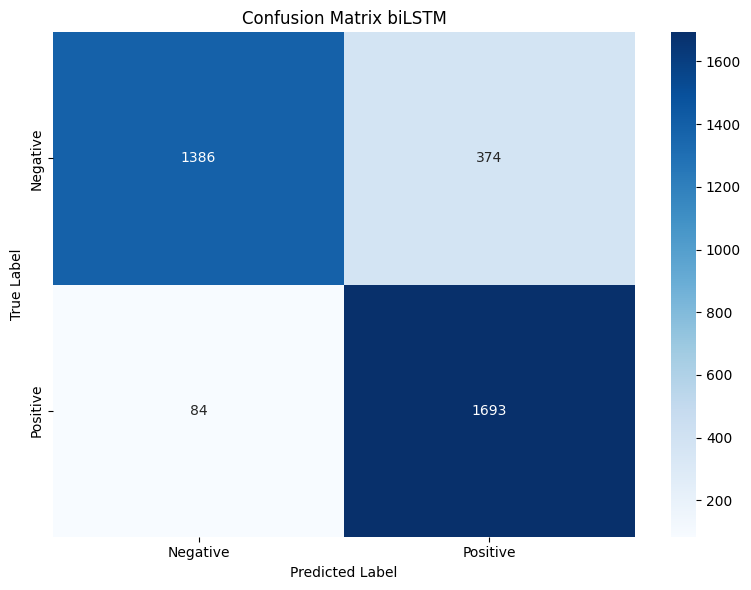

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      1760
           1       0.82      0.95      0.88      1777

    accuracy                           0.87      3537
   macro avg       0.88      0.87      0.87      3537
weighted avg       0.88      0.87      0.87      3537



In [ ]:
if __name__ == "__main__":
    # Load the dataset
    df = pd.read_csv("/content/drive/MyDrive/Social Bot detection/Twibot/english_data.csv")

    # Train the LSTM model
    model, tokenizer, history, evaluation, biLSTM_classification = train_lstm_model(df)



#Decision Tree Algorithm

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Classification Report:
              precision    recall  f1-score   support

       Human       0.57      0.90      0.70      1201
         Bot       0.89      0.55      0.68      1777

    accuracy                           0.69      2978
   macro avg       0.73      0.72      0.69      2978
weighted avg       0.76      0.69      0.69      2978

ROC AUC Score: 0.8853


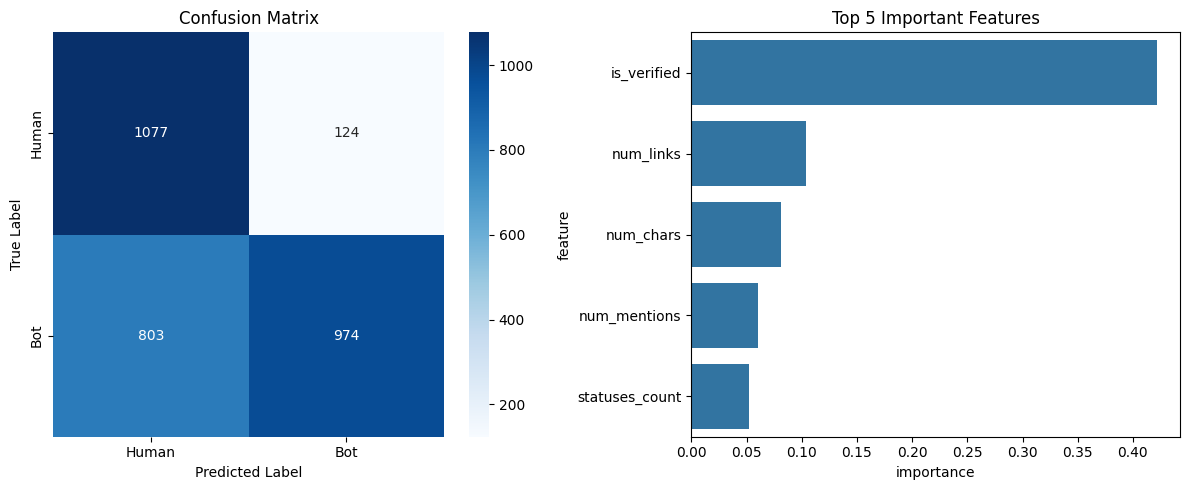

In [ ]:

def prepare_features(df):
    """
    Prepare features for the Decision Tree model
    """
    feature_columns = [
        'account_age', 'favorites_count', 'friends_follower_ratio',
        'listed_count', 'num_followers', 'num_friends', 'tweet_length',
        'statuses_count', 'is_verified', 'num_links', 'num_hashtags',
        'num_mentions', 'num_chars','sentiment_polarity'
    ]

    # Use float32 to reduce memory usage
    X = df[feature_columns].astype('float32')
    df = df.dropna(subset=['label'])
    y = df['label']

    return X, y

# Train Decision Tree Model
def train_decision_tree(X, y):
    """
    Train and tune a Decision Tree model
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Apply ADASYN for class balancing
    adasyn = ADASYN(random_state=42)
    X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

    # Define parameter grid for RandomizedSearchCV
    param_grid = {
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }

    # Initialize Decision Tree Classifier
    dt = DecisionTreeClassifier(random_state=42, class_weight={0: 3, 1: 1})

    # Use RandomizedSearchCV for tuning
    random_search = RandomizedSearchCV(
        estimator=dt,
        param_distributions=param_grid,
        n_iter=10,  # Number of parameter combinations to try
        cv=3,       # Number of cross-validation folds
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    # Fit the model
    random_search.fit(X_train_resampled, y_train_resampled)

    # Get best model
    best_model = random_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    return best_model, X_test, y_test, y_pred, y_proba

# Evaluate Decision Tree Model
def evaluate_model(model, X_test, y_test, y_pred, y_proba):
    """
    Evaluate the Decision Tree model and display results
    """
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))

    # Calculate and print ROC AUC Score
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Human', 'Bot'],
                yticklabels=['Human', 'Bot'],
                ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')

    # Feature Importance (top 5 only)
    feature_importance = pd.DataFrame({
        'feature': X_test.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head()

    sns.barplot(x='importance', y='feature', data=feature_importance, ax=ax2)
    ax2.set_title('Top 5 Important Features')

    plt.tight_layout()
    plt.show()
    cr = classification_report(y_test, y_pred, output_dict=True)

    # Convert classification report to a DataFrame for easier viewing
    DT_df = pd.DataFrame(cr).transpose()
    return feature_importance, DT_df

# Example usage
if __name__ == "__main__":
    # Load the dataset
    df = pd.read_csv("/content/drive/MyDrive/Social Bot detection/Twibot/english_data.csv")

    # Prepare the features and labels
    X, y = prepare_features(df)

    # Train the Decision Tree model
    best_model, X_test, y_test, y_pred, y_proba = train_decision_tree(X, y)

    # Evaluate the model
    evaluate_model(best_model, X_test, y_test, y_pred, y_proba)

#Random Forest


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best Parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': {0: 3, 1: 1}, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Classification Report:
              precision    recall  f1-score   support

       Human       0.87      0.75      0.81      1201
         Bot       0.85      0.92      0.88      1777

    accuracy                           0.85      2978
   macro avg       0.86      0.84      0.84      2978
weighted avg       0.85      0.85      0.85      2978

ROC AUC Score: 0.8966


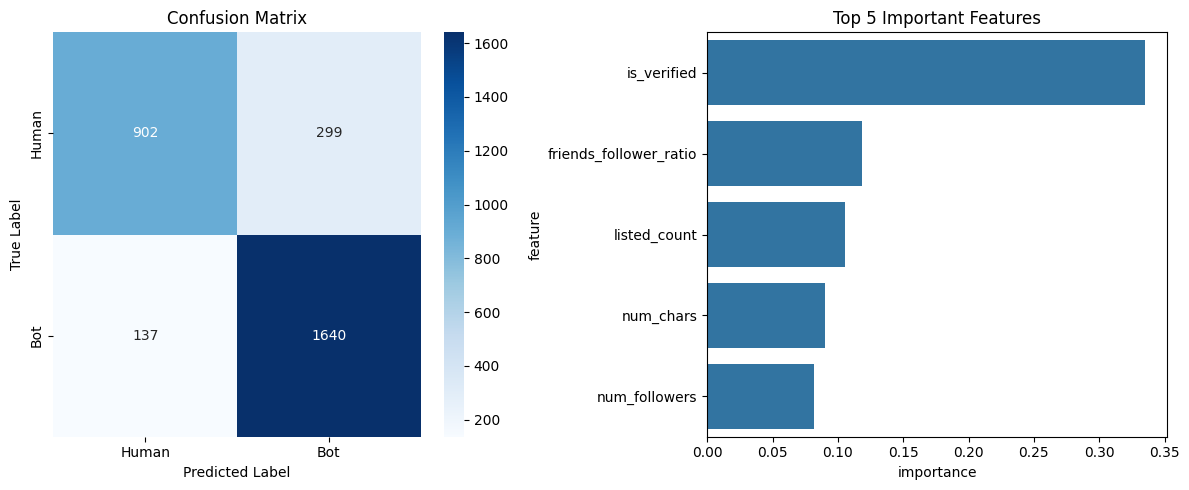

In [ ]:
def prepare_features(df):
    feature_columns = [
        'account_age',
        'favorites_count',
        'friends_follower_ratio',
        'listed_count',
        'num_followers',
        'num_friends',
        'tweet_length',
        'statuses_count',
        'is_verified',
        'num_links',
        'num_hashtags',
        'num_mentions',
        'num_chars'
    ]

    X = df[feature_columns]
    df = df.dropna(subset=['label'])
    y = df['label']

    return X, y

def train_best_model(X, y):

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Apply SMOTe for class balancing
    smote = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Define parameter grid for RandomizedSearchCV
    param_grid = {
        'n_estimators': [200, 500, 1000],
        'max_depth': [10, 20, 30,],
        'min_samples_split': [5, 10,20],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }

    # Initialize Random Forest Classifier
    rf = RandomForestClassifier(random_state=42, class_weight={0: 3, 1: 1})

    # Use RandomizedSearchCV for tuning
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_grid,
        n_iter=20,  # Try 10 parameter combinations
        cv=5,       # 5-fold CV
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    # Fit the model with parallel backend
    with parallel_backend('threading', n_jobs=-1):
        random_search.fit(X_train_resampled, y_train_resampled)

    # Get best model
    best_model = random_search.best_estimator_

    # Make predictions
    y_proba = best_model.predict_proba(X_test)[:, 1]

    # Apply threshold adjustment for prediction
    threshold = 0.6
    y_pred_adjusted = (y_proba >= threshold).astype(int)

    return best_model, X_train, X_test, y_train, y_test, y_pred_adjusted, y_proba

def evaluate_model(model, X_test, y_test, y_pred, y_proba, feature_names):
    """
    Evaluate the model and display results
    """
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))

    # Calculate and print ROC AUC Score
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # Create simplified visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Human', 'Bot'],
                yticklabels=['Human', 'Bot'],
                ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')

    # Feature Importance (top 5 only)
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head()

    sns.barplot(x='importance', y='feature', data=feature_importance, ax=ax2)
    ax2.set_title('Top 5 Important Features')

    plt.tight_layout()
    plt.show()

    cr = classification_report(y_test, y_pred, output_dict=True)

    # Convert classification report to a DataFrame for easier viewing
    cr_df = pd.DataFrame(cr).transpose()
    return feature_importance

def predict_new_data(model, new_data):
    """
    Predict new data using the trained model
    """
    predictions = model.predict(new_data)
    probabilities = model.predict_proba(new_data)

    return predictions, probabilities
# Example usage
if __name__ == "__main__":
    # Load the dataset
    df = pd.read_csv("/content/drive/MyDrive/Social Bot detection/Twibot/english_data.csv")

    # Prepare the features and labels
    X, y = prepare_features(df)

    # Train the best model
    best_model, X_train, X_test, y_train, y_test, y_pred, y_proba = train_best_model(X, y)
    print("\nBest Parameters:")
    print(best_model.get_params())
    # Evaluate the model
    feature_names = X.columns
    evaluate_model(best_model, X_test, y_test, y_pred, y_proba, feature_names)
